In [1]:
# DATASET_NUM = 0
DATASET_NUM = 1

import pandas as pd

pair_list = ["BTCUSDT","SOLUSDT","ETHUSDT"]
dataset = pd.read_parquet(f"data/dataset_{DATASET_NUM}.parquet")

btc = dataset[dataset.PAIR == "BTCUSDT"]
eth = dataset[dataset.PAIR == "ETHUSDT"]
sol = dataset[dataset.PAIR == "SOLUSDT"]

In [2]:
eth = eth.drop(columns=["PAIR","open","high","low"])
eth.columns

Index(['close', 'volume', 'qav', 'num_trades', 'taker_base_vol',
       'taker_quote_vol'],
      dtype='object')

In [3]:
eth["price_var"] = eth["close"].diff()
eth["next_price_var"] = eth["close"].diff().shift(-1)
lag = 5 

for i in range(1, lag):
    eth[f"price_var_lag_{i}"] = eth["price_var"].shift(i)

eth = eth.iloc[lag:-1]  # to drop nan generated by shifts

In [4]:
eth.tail(3)

,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,price_var,next_price_var,price_var_lag_1,price_var_lag_2,price_var_lag_3,price_var_lag_4
2025-04-16 23:59:57,1591.79,14.9834,23847.613514,56.0,14.9834,23847.613514,0.19,0.10,0.01,0.01,0.27,-0.01
2025-04-16 23:59:58,1591.89,0.0744,118.432205,15.0,0.0744,118.432205,0.10,0.14,0.19,0.01,0.01,0.27
2025-04-16 23:59:59,1592.03,0.8854,1409.480708,27.0,0.8854,1409.480708,0.14,0.25,0.10,0.19,0.01,0.01


Random forest regressor

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Features and target
X = eth.drop(columns=["next_price_var"])
y = eth["next_price_var"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0422
R-squared (R²): -0.0141


In [7]:
from catboost import CatBoostRegressor
import numpy as np
# Train Catboost
model = CatBoostRegressor(verbose = 0, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Sign accuracy: correct direction (up/down)
sign_accuracy = (np.sign(y_pred) == np.sign(y_test)).mean()

print(f"Sign Accuracy: {sign_accuracy:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Sign Accuracy: 0.3835
Mean Squared Error (MSE): 0.0413
R-squared (R²): 0.0077


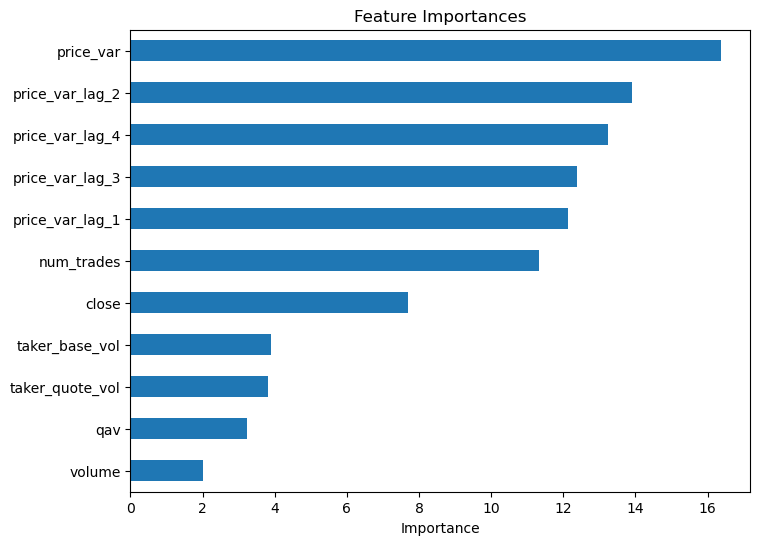

In [8]:
# Feature importances
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

# Sort and plot
feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()

## Random forest classifier

In [9]:
sigma = eth["next_price_var"].std()

eth["target"] = eth["next_price_var"].apply(
                    lambda x: -1 if x < -sigma else (1 if x > sigma else 0)
                    )
X = eth.drop(columns=["next_price_var", "target"])
y = eth["target"]

X = X.dropna()
y = y.loc[X.index]

Accuracy: 0.8220

Classification Report:
              precision    recall  f1-score   support

          -1       0.33      0.02      0.04      4661
           0       0.83      1.00      0.90     42614
           1       0.37      0.02      0.04      4564

    accuracy                           0.82     51839
   macro avg       0.51      0.35      0.33     51839
weighted avg       0.74      0.82      0.75     51839



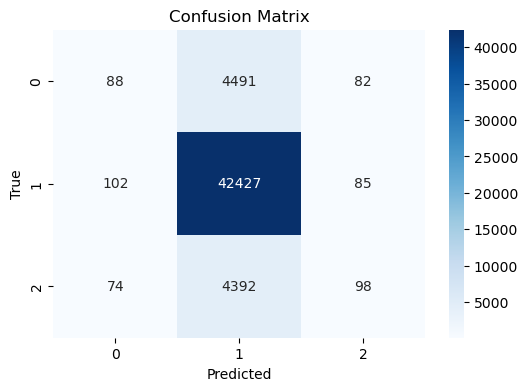

In [10]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train Catboost Classifier
clf = CatBoostClassifier(verbose=0,random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# # Feature Importances
# importances = clf.feature_importances_
# feat_importances = pd.Series(importances, index=X.columns)

# feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
# plt.title('Feature Importances')
# plt.xlabel('Importance')
# plt.show()
